<a href="https://colab.research.google.com/github/SJinji/satellite-image-semantic-segmentation-/blob/main/Semantic_Segmentation_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if torch.cuda.is_available():
  DEVICE = "cuda"
else:
  DEVICE = "cpu"
print(f"Using {DEVICE}.")
if gpu_info.find('failed') >= 0:
  if DEVICE == "cpu":
    print('Not connected to a GPU')
else:
  if DEVICE == "cuda":
    print(gpu_info)

Using cuda.
Thu Jun  1 15:10:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    44W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                            

In [ ]:
! mkdir Hurricane_Harvey 
! mkdir Hurricane_Harvey/rasters Hurricane_Harvey/vectors 
! gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw Hurricane_Harvey/rasters/ 
! gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ Hurricane_Harvey/vectors/

In [55]:
! pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import imageio
import cv2

import time

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# **Check Dataset**

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4000, 'height': 3000, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.352761268592593e-07, 0.0, -95.74172973632812,
       0.0, -2.9139477919088347e-07, 29.64449788042774)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4000, 'height': 3000, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.6763806343078613e-07, 0.0, -95.72284698486328,
       0.0, -1.457334360936933e-07, 29.619131910181057)}


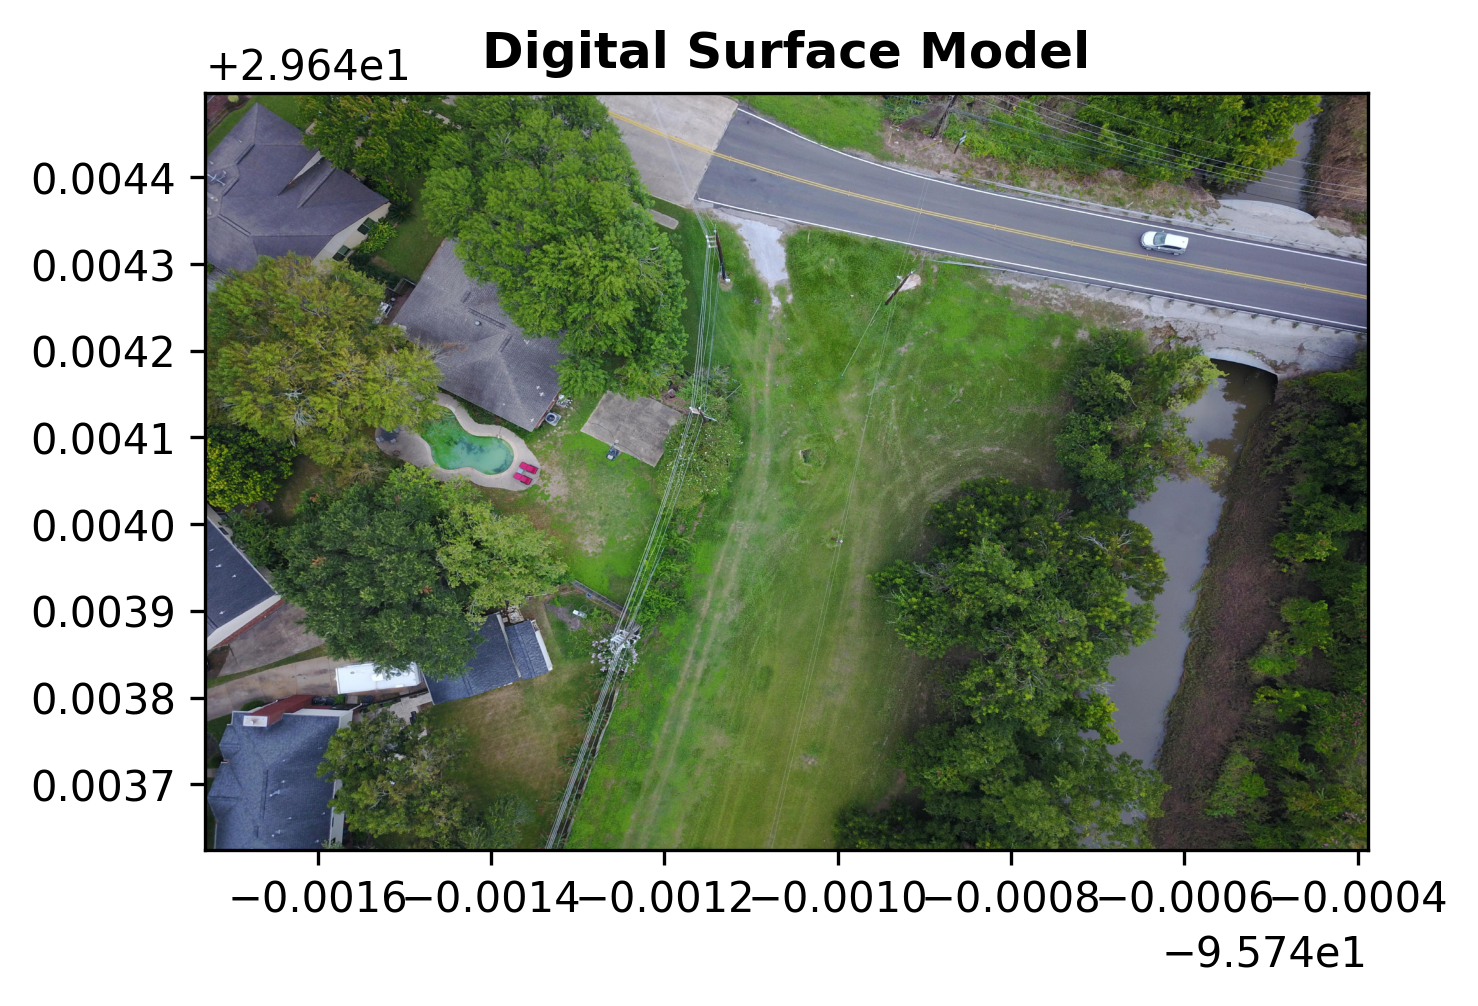

<Axes: title={'center': 'Digital Surface Model'}>

In [57]:
# Open the two rasters 
dsm = rasterio.open("/content/Hurricane_Harvey/rasters/raw/6559.tif", driver="GTiff")
dtm = rasterio.open("/content/Hurricane_Harvey/rasters/raw/10171.tif", driver="GTiff")

# Metadata functions from Rasterio
print(dsm.meta)
print(dtm.meta)

# Plot with rasterio.plot, which provides Matplotlib functionality
plt.figure(figsize=(5, 5), dpi=300)  # adjust size and resolution
show(dsm, title='Digital Surface Model', cmap='gist_ncar')

In [58]:
# Rasterio object
print(type(dsm))

# Read, show object type and data
dsm_data = dsm.read(1)
print(type(dsm_data))
print(dsm_data)

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
[[73 68 63 ... 85 78 72]
 [68 65 63 ... 74 78 79]
 [62 63 64 ... 67 77 83]
 ...
 [37 36 36 ... 94 94 91]
 [39 36 32 ... 92 93 89]
 [43 37 30 ... 90 91 87]]


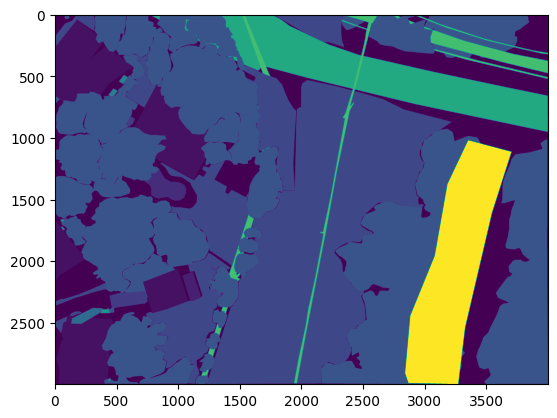

In [59]:
# check masks image
im = Image.open('/content/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks/6559.png')
plt.imshow(im)
plt.show()

In [60]:
# check masks data   
print(type(im))
print(im.mode)
print(im.getpalette())

<class 'PIL.PngImagePlugin.PngImageFile'>
L
None


In [61]:
im = np.array(im)
print(im.shape)

(3000, 4000)


# **Data Augmentation**

In [62]:
# Hyperparameters
HEIGHT = 512
WIDTH  = 512

In [63]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
! unzip /content/drive/MyDrive/DL_kaggle/train.zip
! unzip /content/drive/MyDrive/DL_kaggle/test.zip
! unzip /content/drive/MyDrive/DL_kaggle/Masks.zip

In [102]:
# Specify paths to your files (glob glob stores paths to all files in a folder in a list)
root = os.getcwd()
train_img_link_list  = sorted(glob.glob('/content/train/*'))
train_mask_link_list = sorted(glob.glob('/content/Masks/*'))
test_img_link_list   = sorted(glob.glob('/content/test/*'))

In [103]:
len(train_img_link_list)

299

In [105]:
len(train_mask_link_list)

299

In [106]:
len(test_img_link_list)

75

In [ ]:
! mkdir Hurricane_Harvey/train_images_512
! mkdir Hurricane_Harvey/train_masks_512
! mkdir Hurricane_Harvey/val_images_512
! mkdir Hurricane_Harvey/val_masks_512
! mkdir Hurricane_Harvey/test_512

In [108]:
# Manual validation set list (handpicked examples):
val_img_list = [6413,6420,6433,6444,6468,6556,6565,6640,6716,7690,8368,8445,8817,8902,7233,
                6706,7256,7316,7321,7335,7521,7575,8917,8960,9107,6824,6843,6905,6966,6969]
val_img_list = [str(x) for x in val_img_list]

# Transformation pipeline
transform_img = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH]),
    transforms.ToTensor() #convert a PIL image to tensor (H*W*C) in range [0,255] to a torch.Tensor(C*H*W) in the range [0.0,1.0]
])

transform_mask = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH], interpolation=Image.NEAREST),
    transforms.ToTensor()
])

transform_mask_prova = transforms.Compose([
    transforms.ToTensor()
])

# Iterate through all masks and images in train set, transform them and store corresponging tensors in a new folder
for i in tqdm(range(len(train_img_link_list))):
    #print(i)
    img_id  = train_img_link_list[i].split('/')[-1].split('.')[0]
    mask_id = train_mask_link_list[i].split('/')[-1].split('.')[0]
    assert img_id == mask_id    # Make sure id's match
      
    img   = Image.open(train_img_link_list[i])
    mask  = Image.open(train_mask_link_list[i])

    img  = transform_img(img)
    mask = transform_mask(mask)*255
    mask = mask.int()
      
    if img_id in val_img_list:
        torch.save(img, f'/content/Hurricane_Harvey/val_images_{HEIGHT}/{img_id}.pt')
        torch.save(mask, f'/content/Hurricane_Harvey/val_masks_{HEIGHT}/{mask_id}.pt')
    else:
        torch.save(img, f'/content/Hurricane_Harvey/train_images_{HEIGHT}/{img_id}.pt')
        torch.save(mask, f'/content/Hurricane_Harvey/train_masks_{HEIGHT}/{mask_id}.pt')
    
print('Train and Validation sets created')

# Iterate through all images in test set, transform them and store corresponging tensors in a new folder
for i in tqdm(range(len(test_img_link_list))):
    
    img_id  = test_img_link_list[i].split('/')[-1].split('.')[0]
    
    img   = Image.open(test_img_link_list[i])
    img   = transform_img(img)
    torch.save(img, f'/content/Hurricane_Harvey/test_{HEIGHT}/{img_id}.pt')
    
    
print('Test set created')
    
#add images of minority classes
min_classses = [7,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
count = 0

for i in tqdm(range(len(train_img_link_list))):
    
    img_id  = train_img_link_list[i].split('/')[-1].split('.')[0]
    mask_id = train_mask_link_list[i].split('/')[-1].split('.')[0]
    assert img_id == mask_id    # Make sure id's match

    img   = Image.open(train_img_link_list[i])
    mask  = Image.open(train_mask_link_list[i])

    img  = transform_img(img)
    mask = transform_mask(mask)*255
    mask = mask.int()

    if len(set(min_classses).intersection(set(mask.unique().tolist()))) > 0:

       cropped_img = T.FiveCrop(size=(HEIGHT//2,WIDTH//2))(img)
       cropped_mask = T.FiveCrop(size=(HEIGHT//2,WIDTH//2))(mask)
        
       for y in range(5):
          list_mask = [o_items for sublist in cropped_mask[y].tolist() for o_items in sublist]
          if any(items in min_classses for items in [o_items for sublist in list_mask for o_items in sublist]):
                
              mask_in_progress = transform_mask_prova(np.array([cropped_mask[y][0].tolist()]))
                
              torch.save(TF.resize(cropped_img[y], size=(HEIGHT, WIDTH)), f'/content/Hurricane_Harvey/train_images_{HEIGHT}/PLUS_{img_id}_{y}.pt')
              torch.save(TF.resize(mask_in_progress.permute(1,2,0), size=(HEIGHT, WIDTH)), f'/content/Hurricane_Harvey/train_masks_{HEIGHT}/PLUS_{img_id}_{y}.pt')
              count += 1
                
print('Additional', count, ' samples created')

100%|██████████| 299/299 [01:30<00:00,  3.31it/s]


Train and Validation sets created


100%|██████████| 75/75 [00:18<00:00,  4.04it/s]


Test set created


  0%|          | 0/299 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 299/299 [01:53<00:00,  2.63it/s]

Additional 1390  samples created


In [109]:
img_tensors_links  = sorted(glob.glob('/content/Hurricane_Harvey/train_images_512/*'))
mask_tensors_links = sorted(glob.glob('/content/Hurricane_Harvey/train_masks_512/*'))
img_tensors_links  = img_tensors_links[-1390:]
mask_tensors_links = mask_tensors_links[-1390:]

In [110]:
len(img_tensors_links)

1390

In [111]:
len(mask_tensors_links)

1390

In [112]:
img_tensors_links[-1390]

'/content/Hurricane_Harvey/train_images_512/PLUS_10170_1.pt'

In [113]:
mask_tensors_links[-1390]

'/content/Hurricane_Harvey/train_masks_512/PLUS_10170_1.pt'

In [114]:
def show_random_images(i, img_links, mask_links):
    
    img = torch.load(img_links[i])
    mask = torch.load(mask_links[i])
    
    f, axarr = plt.subplots(1,2, figsize=(15,15))
    axarr[0].imshow(img.permute(1,2,0).detach().numpy())
    axarr[1].imshow(mask.permute(1,2,0).detach().numpy()[:,:,0])
    plt.show()

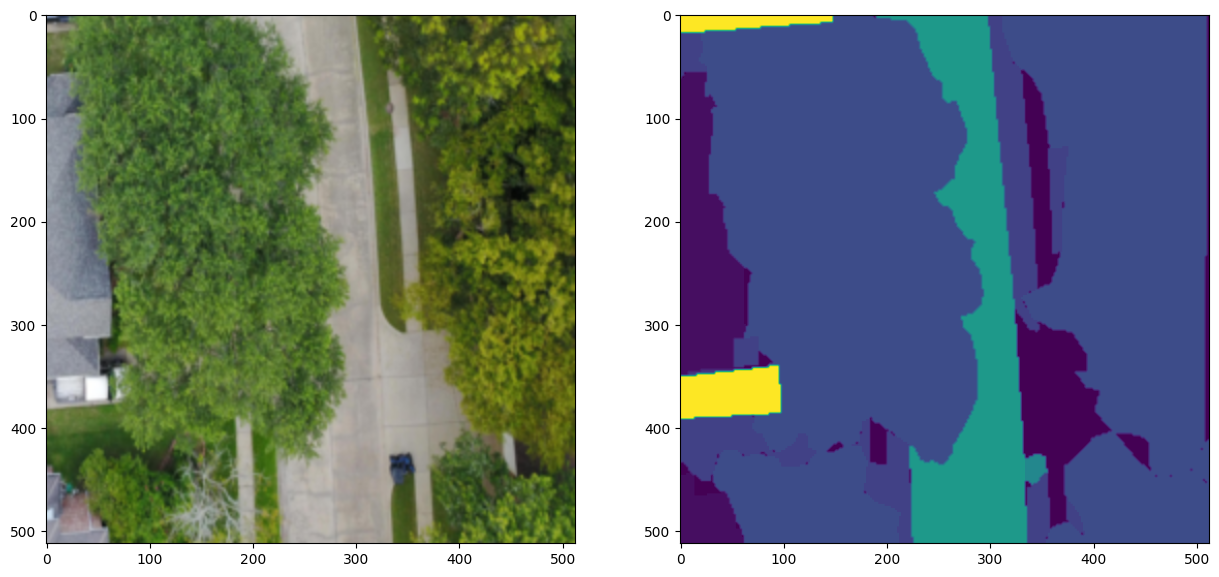

In [115]:
show_random_images(28, img_tensors_links, mask_tensors_links)

# **Customize Dataloader**

In [116]:
# Data preparation Hyperparameters
NUM_CLASSES = 27
#TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 10
HEIGHT = 512    # in the current implementation height and width both need to be divisable by 16
WIDTH  = 512

In [117]:
# Create a custom Dataset class

class tensorDataset(Dataset):
    '''
    Inputs:
    - images: list of strings that specify paths to specific tensors
    e.g: '/Users/jedrzejalchimowicz/Desktop/DSBA - Y2S1/Deep_learning/DL_kaggle/data/train_images_96/img96_0.pt'
    - masks: same as images but for masks
    '''
    
    def __init__(self, images:list, masks:list, train:bool):
        self.image_links = images
        self.mask_links  = masks
        self.train = train
        

    def __getitem__(self, index):
        
        # Select a specific image's link
        img_id  = self.image_links[index]
        mask_id = self.mask_links[index]

        # Load the image (as tensor)
        img  = torch.load(img_id)
        mask = torch.load(mask_id)
        
        # Apply transformations
        if self.train == True:
          img, mask = self.transform(img, mask)
        
        # Squeeze mask from (1, H, W) to (H, W) -> This is because loss function accepts (B, H, W)
        mask = mask.squeeze(0)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        mask = mask.long()
        
        return img, mask

    
    def __len__(self):
        return len(self.image_links)
    
    
    def transform(self, img, mask):
        
        # Some images in the test set are much brighter/darker than others
        temp_rand = np.random.rand()
        if temp_rand < 0.3:
            t_darken_image = T.ColorJitter(brightness=[0.6, 0.8])
            img = t_darken_image(img)
            # Do nothing for mask - the colors don't change
        elif temp_rand > 0.7:
            t_brighten_image = T.ColorJitter(brightness=[1.2, 1.4])
            img = t_brighten_image(img)
            # Do nothing for mask - the colors don't change
        
        # Flipping images makes sense for satelite images
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)
            mask = t_horizonal_flip(mask)
            
        if np.random.rand() < 0.3:
            t_vertical_flip = T.RandomVerticalFlip(p=1)
            img  = t_vertical_flip(img)
            mask = t_vertical_flip(mask)

        # Add rotations
        if np.random.rand() < 0.3:
          t_rotation = T.RandomRotation(degrees=(0, 180))
          img = t_rotation(img)
          mask = t_rotation(mask)


        return img, mask

In [118]:
from torch.utils.data import ConcatDataset
root = os.getcwd()
train_img_link_list  = sorted(glob.glob('/content/Hurricane_Harvey/train_images_512/*'))
train_mask_link_list = sorted(glob.glob('/content/Hurricane_Harvey/train_masks_512/*'))
val_img_link_list    = sorted(glob.glob('/content/Hurricane_Harvey/val_images_512/*'))
val_mask_link_list   = sorted(glob.glob('/content/Hurricane_Harvey/val_masks_512/*'))
test_img_link_list = sorted(glob.glob('/content/Hurricane_Harvey/test_512/*'))

train_dataset = tensorDataset(train_img_link_list, train_mask_link_list, train=True)
val_dataset   = tensorDataset(val_img_link_list, val_mask_link_list, train=False)
test_dataset = tensorDataset(test_img_link_list, val_mask_link_list, train=False)
train_val_dataset = ConcatDataset([train_dataset, val_dataset])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_val_dataloader = DataLoader(train_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Test dataloaders
start = time.time()
for i, batch in enumerate(train_dataloader):
    img_batch, img_mask = batch
    print(img_batch.shape)
    print(img_mask.shape)

for i, batch in enumerate(val_dataloader):
    img_batch, img_mask = batch
    print(img_batch.shape)
    print(img_mask.shape)
      
end = time.time()
print(end - start)

# **Architectures**

## **U_NET**

In [120]:
# U-net is composed of several blocks with pooling in between. Each block consists of 2 convolutions,
# therefore to not repeat code at each block we define a class that summarizes it
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            )
    
    def forward(self, x):
        return self.conv(x)
     

In [121]:

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=25, features=[16, 32, 64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs      = nn.ModuleList()
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.ups        = nn.ModuleList()
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.pool       = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # Down part of U-net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Up part of U-net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            # self.ups.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True))
            self.ups.append(DoubleConv(feature*2, feature))
            
    def forward(self, x):
        skip_connections = []
        
        # Go down the Unet
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # Go through the bottleneck
        x = self.bottleneck(x)
        # Reverse the skip connections list -> first are going to be used the ones added last
        skip_connections = skip_connections[::-1]
        
        # Go up the Unet
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            skip_connection = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](skip_connection)
        
        # Last convolution that changes channel output size
        x = self.final_conv(x)
        return x


## **DeepLabV3**

In [122]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

### Evaluation Metrics

In [130]:
# Define a function to calculate the Dice score
def f1_dice_score(preds, true_mask):

    f1_batch = []

    for i in range(len(preds)):
        f1_image = []
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)
        
        # Change shape of img from [25, H, W] to [H, W]
        img = torch.argmax(img, dim=0)
    
        for label in range(26):
            if torch.sum(mask == label) != 0:
                area_of_intersect = torch.sum((img == label) * (mask == label))
                area_of_img       = torch.sum(img == label)
                area_of_label     = torch.sum(mask == label)
                f1 = 2*area_of_intersect / (area_of_img + area_of_label)
                f1_image.append(f1)
        
        f1_batch.append(np.mean([tensor.cpu() for tensor in f1_image]))
    return np.mean(f1_batch)
    
    
# Accuracy
def accuracy(preds, true_mask):
    '''
    preds should be (B, 25, H, W)
    true_mask should be (B, H, W)
    '''
    accuracy_batch = []

    for i in range(len(preds)):
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)
        
        # Change shape of img from [25, H, W] to [H, W]
        img  = torch.argmax(img, dim=0)
        
        accuracy_batch.append(torch.sum(img == mask).item() / (HEIGHT*WIDTH))  # FIX LATER
        
    return np.mean(accuracy_batch)

In [135]:
def train():

  min_val_f1 = 0.3
  total_train_losses = []
  total_train_accuracy = []
  total_train_f1 = []
  total_val_losses = []
  total_val_accuracy = []
  total_val_f1 = []

  for epoch in range(STARTING_EPOCH+1, STARTING_EPOCH+EPOCHS+1):
      
      # Train model
      model.train()
      train_losses   = []
      train_accuracy = []
      train_f1       = []
      
      for i, batch in enumerate(train_val_dataloader):
          #Extract data, labels
          img_batch, mask_batch = batch   #img [B,3,H,W], mask[B,H,W]
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          #Train model
          optimizer.zero_grad()
          with torch.cuda.amp.autocast():
            output = model(img_batch) # output: [B, 26, H, W]
            loss   = criterion(output, mask_batch)
            loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 6)
          optimizer.step()

          #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
          f1 = f1_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          train_losses.append(loss.item())
          train_accuracy.append(acc)
          train_f1.append(f1)
          #print(f'Train Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')
      
      # Update global metrics
      print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, f1: {np.mean(train_f1):.3f}, accuracy: {np.mean(train_accuracy):.3f}')        
      total_train_losses.append(np.mean(train_losses))
      total_train_accuracy.append(np.mean(train_accuracy))
      total_train_f1.append(np.mean(train_f1))
      
      
      # Validate model
      model.eval()
      val_losses   = []
      val_accuracy = []
      val_f1       = []
      
      for i, batch in enumerate(val_dataloader):
          #Extract data, labels
          img_batch, mask_batch = batch
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          #Validate model
          with torch.cuda.amp.autocast():
            output = model(img_batch)
            loss   = criterion(output, mask_batch)

          #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
          f1 = f1_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          val_losses.append(loss.item())
          val_accuracy.append(acc)
          val_f1.append(f1)
          
          # print(f'Val Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')
      
      # Update global metrics
      print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, f1: {np.mean(val_f1):.3f}, accuracy: {np.mean(val_accuracy):.3f}')
      print('---------------------------------------------------------------------------------')
      total_val_losses.append(np.mean(val_losses))
      total_val_accuracy.append(np.mean(val_accuracy))
      total_val_f1.append(np.mean(val_f1))
      
      
      # Save the model
      torch.save(model.state_dict(), f'/content/drive/MyDrive/DL_kaggle/models/deeplabV3+/e_{epoch}.pt')
      
      # Save the results so far
      temp_df = pd.DataFrame(list(zip(total_train_losses, total_val_losses, total_train_f1, total_val_f1,
                                    total_train_accuracy, total_val_accuracy)),
                            columns = ['train_loss', 'val_loss', 'train_f1', 'test_f1', 'train_accuracy',
                                      'test_accuracy'])
      temp_df.to_csv('train_val_measures')

### Train workflow


In [136]:
# Initialization
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

################### UNET ###################
# model = UNET(in_channels=3, out_channels=25).to(DEVICE)
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/FDL_kaggle_data/models/modelBIG_52.pt'))

In [143]:
############### DeepLabV3Plus ##############

# create segmentation model without pretrained encoder- DeepLabV3Plus
model = smp.DeepLabV3Plus(
     encoder_name = 'resnet101', 
     encoder_weights = 'imagenet', 
     classes = 27, 
     activation = None # could be None for logits or 'softmax2d' for multiclass segmentation
 ).to(DEVICE)
#model.load_state_dict(torch.load(f'/content/drive/MyDrive/DL_kaggle/models/deeplab_512_trainval/e_70.pt'))


In [ ]:
################## PSPNet ##################
'''
#Creating a segmentation model with PSPNet
model = smp.PSPNet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 25, 
    activation = None, # could be None for logits or 'softmax2d' for multiclass segmentation
).to(DEVICE)
'''

In [144]:
# HYPERPARAMETERS for training run
STARTING_EPOCH = 50
EPOCHS = 50
LR = 0.000001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss().to(DEVICE)

train()

TRAIN       Epoch: 51 | Epoch metrics | loss: 3.3084, f1: 0.020, accuracy: 0.079
VALIDATION  Epoch: 51 | Epoch metrics | loss: 3.2169, f1: 0.056, accuracy: 0.132
---------------------------------------------------------------------------------
TRAIN       Epoch: 52 | Epoch metrics | loss: 3.1772, f1: 0.033, accuracy: 0.148
VALIDATION  Epoch: 52 | Epoch metrics | loss: 3.0991, f1: 0.082, accuracy: 0.217
---------------------------------------------------------------------------------
TRAIN       Epoch: 53 | Epoch metrics | loss: 3.0529, f1: 0.047, accuracy: 0.223
VALIDATION  Epoch: 53 | Epoch metrics | loss: 2.9420, f1: 0.109, accuracy: 0.317
---------------------------------------------------------------------------------
TRAIN       Epoch: 54 | Epoch metrics | loss: 2.9312, f1: 0.062, accuracy: 0.302
VALIDATION  Epoch: 54 | Epoch metrics | loss: 2.8226, f1: 0.142, accuracy: 0.405
---------------------------------------------------------------------------------
TRAIN       Epoch: 55 | 

# Make Predictions

In [147]:
model = smp.DeepLabV3Plus(
     encoder_name = 'resnet101', 
     encoder_weights = 'imagenet', 
     classes = 27, 
     activation = None # could be None for logits or 'softmax2d' for multiclass segmentation
 ).to(DEVICE)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/DL_kaggle/models/deeplabV3+/e_100.pt'))

<All keys matched successfully>

In [148]:
# Get a batch from validation set
img, mask = next(iter(train_dataloader))
model.cpu()
img = img
output = model(img)     

In [149]:
from matplotlib import colors

# Define function for plotting images
def show_random_images(i, img, output, true_mask):
    '''
    img <- image tensor [B,3,H,W]
    output <- output of model as [B,25,H,W] tensor
    true_mask <- mask tensor [B,H,W]
    All three elements must match, index i in img must correstpond to index i in output and true mask
    '''
    # Get preiction from output
    pred_mask  = torch.argmax(output, dim=1)
    
    # Get one image/mask only from the list, based on passed index 'i'
    img = img[i].cpu()
    pred_mask = pred_mask[i].cpu()
    true_mask = true_mask[i].cpu()
    
    # Add dummy pixels in the top left <- ensures colors assigned to each class by matplotlib match in both masks
    for i in range(26):
      pred_mask[0][i] = i
      true_mask[0][i] = i

    # Plot
    f, axarr = plt.subplots(1,3, figsize=(25,20))
    axarr[0].imshow(img.permute(1,2,0).detach().numpy())
    axarr[1].imshow(true_mask, cmap='tab20')
    axarr[2].imshow(pred_mask, cmap='tab20')

    plt.show()

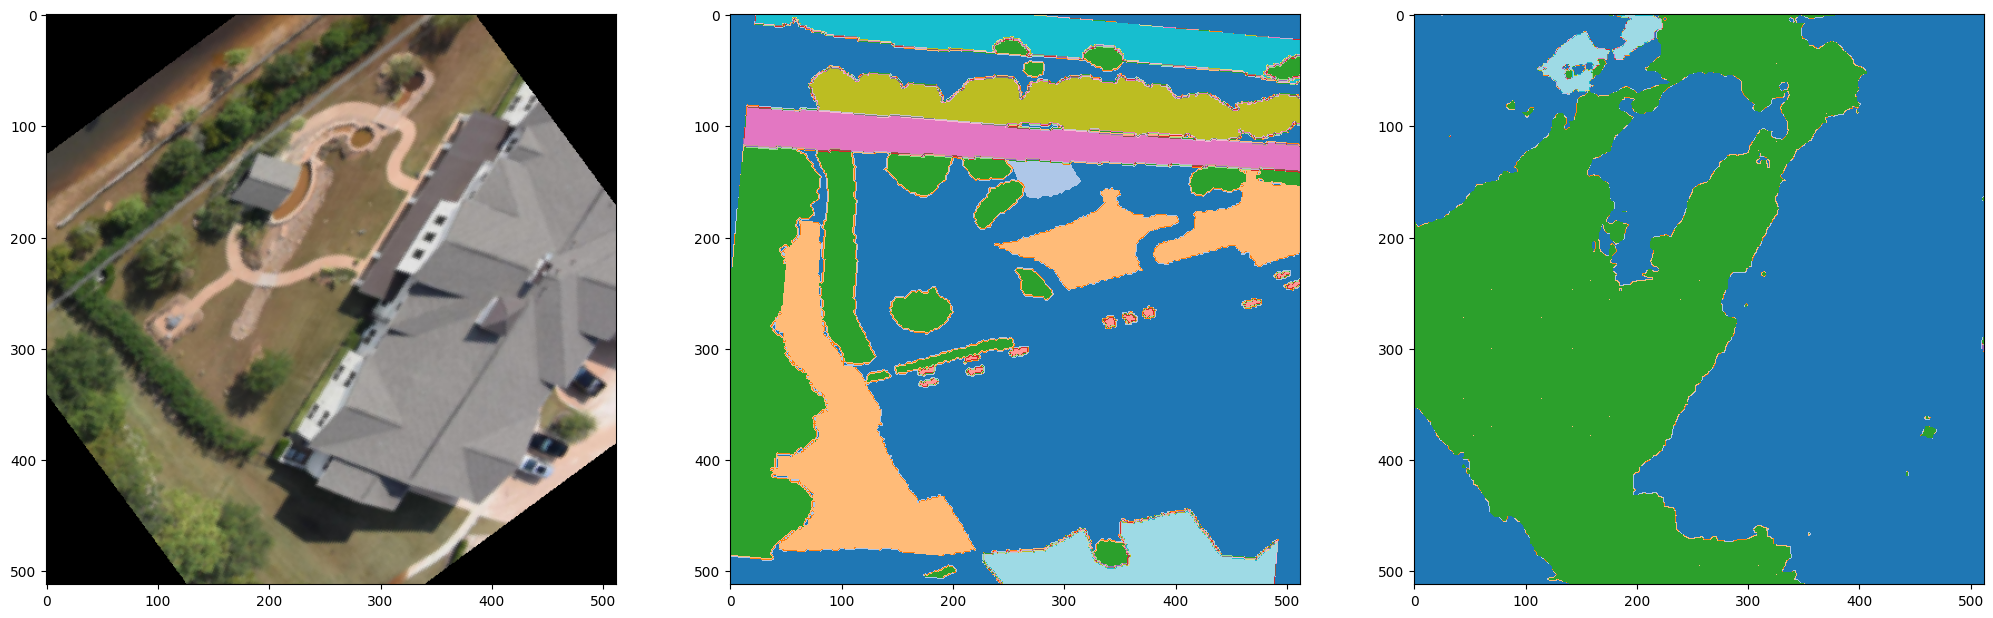

In [150]:
# LEFT: the image, MIDDLE: true mask, RIGHT: our prediction
show_random_images(0, img, output, mask)

In [151]:
# Load test images
test_img_link_list = sorted(glob.glob('/content/Hurricane_Harvey/test_512/*'))
torch_list = [torch.load(link) for link in test_img_link_list]

In [152]:
# CHECK 1: how many test pictures in folder
len(torch_list)

75

In [153]:
test_img_org_list = sorted(glob.glob('/content/test/*'))
img_org = Image.open(test_img_org_list[7])
img_org = np.array(img_org)
img_org.shape
#size = (img_org.shape[1], img_org.shape[0])
#size

(3000, 4000, 3)

In [154]:
! mkdir Hurricane_Harvey/test_pred_512_trainval_v2

In [155]:
model.eval()

# calculate output for each image in test set and save the prediction in new folder
for i in tqdm(range(len(torch_list))):
  img_id = test_img_link_list[i].split('/')[-1].split('.')[0]
  img = torch_list[i].unsqueeze(0)
  img_org = Image.open(test_img_org_list[i])
  img_org = np.array(img_org)
  size = (img_org.shape[1], img_org.shape[0])
  output = model(img)
  output = torch.argmax(output, dim=1).squeeze(0) # combine 27 channels into 1 channel
  output = np.uint8(output) # convert into greyscale (before, x255 to avoid longtensor round down)
  output = cv2.resize(output, size, interpolation = cv2.INTER_NEAREST)
  output = Image.fromarray(output)
  
  output.save(f"/content/Hurricane_Harvey/test_pred_512_trainval_v2/{img_id}.png")

100%|██████████| 75/75 [00:53<00:00,  1.41it/s]


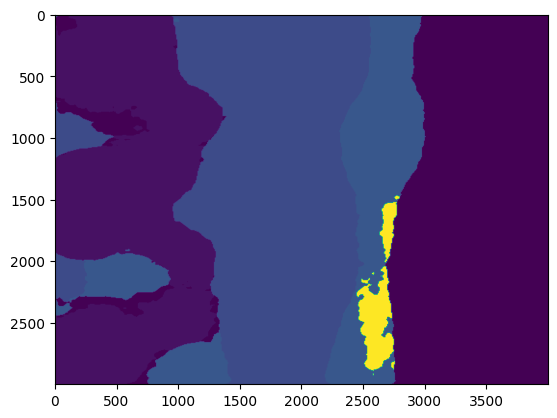

In [156]:
# check masks image
im = Image.open('/content/Hurricane_Harvey/test_pred_512_trainval_v2/10300.png')
plt.imshow(im)
plt.show()

In [157]:
print(type(im))
print(im.mode)
print(im.getpalette())

<class 'PIL.PngImagePlugin.PngImageFile'>
L
None


In [158]:
im = np.array(im)
print(im.shape)

(3000, 4000)


In [159]:
# CHECK 2: how many predicted images in folder
temp = sorted(glob.glob('/content/Hurricane_Harvey/test_pred_512_trainval_v2/*'))
len(temp)

75

In [160]:
import tarfile

tar = tarfile.open("submission_512_trainval_v2.tar", "w")

for root, dir, files in os.walk('/content/Hurricane_Harvey/test_pred_512_trainval_v2'):
    for  file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()